In [1]:
import polars as pl
import numpy as np
import os 

# Import Data & Initial Inspection

In [2]:
# Edges tells me there is an edge between these two numbers. (0, 173) means there is a 
# an edge between node 0 and node 173

edges = pl.read_csv("./data/edges.csv").rename({"0":"from_node_id", "1":"to_node_id"})
print(edges.shape)
print(edges.select([
    pl.col("from_node_id").min().alias("min"),
    pl.col("from_node_id").max().alias("max")
]))
edges_list = edges.groupby("from_node_id").agg([
    pl.col("to_node_id")
])
print(edges_list.head())
del edges # save memory

(430548, 2)
shape: (1, 2)
┌─────┬──────┐
│ min ┆ max  │
│ --- ┆ ---  │
│ i64 ┆ i64  │
╞═════╪══════╡
│ 0   ┆ 5793 │
└─────┴──────┘
shape: (5, 2)
┌──────────────┬────────────────────┐
│ from_node_id ┆ to_node_id         │
│ ---          ┆ ---                │
│ i64          ┆ list[i64]          │
╞══════════════╪════════════════════╡
│ 928          ┆ [23, 24, ... 5676] │
│ 288          ┆ [4, 5, ... 5558]   │
│ 2832         ┆ [73, 74, ... 5757] │
│ 3696         ┆ [95, 96, ... 5773] │
│ 2624         ┆ [67, 68, ... 5733] │
└──────────────┴────────────────────┘


In [3]:
# Is the node an anomly?

labels = pl.read_csv("./data/labels.csv").rename({"0":"is_anomoly"})
labels = labels.with_columns([
    pl.arange(0, len(labels), 1).alias("node_id")
])
print(labels.shape)
labels.head()

(5794, 2)


is_anomoly,node_id
f64,i64
1.0,0
0.0,1
1.0,2
0.0,3
1.0,4


In [4]:
# Values hold by the node

nodes = pl.read_csv("./data/nodes.csv").with_columns([
    pl.arange(0, len(labels), 1).alias("node_id")
])

print(nodes.shape)
nodes.head() 

(5794, 5)


0,1,2,3,node_id
f64,f64,f64,f64,i64
5.0,3.0,1.0,29.0,0
5.0,3.0,1.0,29.0,1
5.0,47.0,1.0,29.0,2
5.0,47.0,1.0,29.0,3
5.0,47.0,1.0,29.0,4


In [5]:
# Each column has a finite set of unique values. 
for c in nodes.columns:
    if c != "node_id":
        check = nodes.select([
            pl.col(c).unique()
        ])
        print(len(check))
        print(check.get_column(c).to_list())

9
[0.0, 1.0, 3.0, 5.0, 17.0, 21.0, 34.0, 40.0, 48.0]
14
[0.0, 3.0, 11.0, 13.0, 17.0, 29.0, 30.0, 42.0, 44.0, 45.0, 47.0, 48.0, 52.0, 54.0]
9
[0.0, 1.0, 3.0, 5.0, 17.0, 21.0, 34.0, 40.0, 48.0]
14
[0.0, 3.0, 11.0, 13.0, 17.0, 29.0, 30.0, 42.0, 44.0, 45.0, 47.0, 48.0, 52.0, 54.0]


In [6]:
# create a flat table with the following schema
# node id, its values, its label, neighbor id, neighbor's values

fact = nodes.join(labels, on="node_id").join(edges_list, left_on="node_id", right_on="from_node_id")\
        .explode("to_node_id")\
        .join(labels, left_on="to_node_id", right_on="node_id")\
        .join(nodes, left_on="to_node_id", right_on="node_id")\
        .sort(["node_id", "to_node_id"])
fact.head() 

0,1,2,3,node_id,is_anomoly,to_node_id,is_anomoly_right,0_right,1_right,2_right,3_right
f64,f64,f64,f64,i64,f64,i64,f64,f64,f64,f64,f64
5.0,3.0,1.0,29.0,0,1.0,173,1.0,1.0,29.0,5.0,47.0
5.0,3.0,1.0,29.0,0,1.0,174,0.0,1.0,29.0,5.0,47.0
5.0,3.0,1.0,29.0,0,1.0,245,1.0,1.0,29.0,5.0,47.0
5.0,3.0,1.0,29.0,0,1.0,246,0.0,1.0,29.0,5.0,47.0
5.0,3.0,1.0,29.0,0,1.0,321,0.0,1.0,29.0,5.0,3.0


# Idea 1

Given a node, how many of its (immediate) neighbors are also anomalies? If "most" of its neighbors are anomolies, then this node is more likely to be an anomoly too.

1. Given the fact table, this is just an aggregation task.

2. Find a threshold that gives us the best result. Let's optimize using f1 because I do not have any context to make any good choice between precision / recall. 

In [7]:
from sklearn.metrics import f1_score, classification_report

In [8]:
scores = []
search_space = np.linspace(0., 1., num=100)
def make_prediction(threshold:float):
    pred = fact.groupby(["node_id", "is_anomoly"]).agg([
        pl.col("is_anomoly_right").sum().alias("nbr_anomoly_count"),
        pl.count().alias("nbr_count")
    ]).with_columns([
        (pl.col("nbr_anomoly_count")/pl.col("nbr_count")).alias("pct")
    ]).with_columns([
        pl.when(pl.col("pct") > threshold).then(1).otherwise(0).alias("prediction")
    ])

    actual = pred.get_column("is_anomoly").to_numpy().ravel()
    predicted = pred.get_column("prediction").to_numpy().ravel()
    
    return actual, predicted

for threshold in search_space:
    actual, predicted = make_prediction(threshold)
    scores.append(f1_score(actual, predicted))

best_threshold = np.argmax(scores)
print(scores[best_threshold])
actual, predicted = make_prediction(search_space[best_threshold])
print(classification_report(actual, predicted))

0.5832414553472988
              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92      4666
         1.0       0.77      0.47      0.58      1128

    accuracy                           0.87      5794
   macro avg       0.83      0.72      0.75      5794
weighted avg       0.86      0.87      0.86      5794



In [9]:
# So it looks like we only beat baseline accuracy by 7%
base_line_accuracy = 4666/5794
print(base_line_accuracy)

0.8053158439765274


# Idea 2

Given a node, we look at aggregated values for all its neighbors, and apply some ML algorithms to see if there exists a logic that tells us whether this node is an anomaly or not.

One problem with this approach is that we do not know what is the best aggregate metric to use for the neighbors. In this case, I chose mean, but it might be median/min/max. We will have a sense of what is the best aggregate metric to choose if we know some business context.

Most values are in fact discrete (by inspection). I will not perform scaling. Should I treat them as categorical? Maybe not. The numbers are discrete because I am working with this "test" dataset. I do not want to make wild assumptions.

#### Execution Steps

1. First we have to create a dataset with each node as a row, and aggregaed values from its neighbors in the same row as well as the label for each node.

2. Do some (ideally) EDA.

3. Train ML algorithms to do binary classification. Given time constraint, I will only use logistic regression, SVM, and random forest, XGBoost, and a shallow neural network and I will not perform grid search, nor tuning.

4. Select the best model.

In [10]:
# We want to create a dataset containing data for each node
# and aggregated data from all the node's neighbors
data = fact.groupby(["0", "1", "2", "3", "node_id","is_anomoly"]).agg([
    pl.col("0_right").mean(), 
    pl.col("1_right").mean(), 
    pl.col("2_right").mean(), 
    pl.col("3_right").mean(),
    pl.count().alias("neighbor_count")
])

In [11]:
# One interesting find is that
# Column 2 = mean of 0 of all its neighbors, and 3 = mean of 1 of all its neighbors
# This is true for ALL nodes. 
# I wonder how this dataset is generated :) 
data 

0,1,2,3,node_id,is_anomoly,0_right,1_right,2_right,3_right,neighbor_count
f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,u32
3.0,3.0,5.0,3.0,380,0.0,5.0,3.0,4.658824,15.341176,85
5.0,42.0,5.0,3.0,487,1.0,5.0,3.0,4.909091,16.402597,77
3.0,3.0,3.0,3.0,2428,0.0,3.0,3.0,4.243243,14.364865,74
5.0,47.0,3.0,3.0,2535,0.0,3.0,3.0,6.36,16.266667,75
3.0,3.0,3.0,3.0,4476,0.0,3.0,3.0,4.705128,15.461538,78
3.0,3.0,3.0,3.0,4583,0.0,3.0,3.0,5.77027,15.22973,74
3.0,3.0,5.0,47.0,263,0.0,5.0,47.0,6.194805,13.701299,77
21.0,17.0,5.0,48.0,1052,0.0,5.0,48.0,5.39759,12.518072,83
5.0,47.0,3.0,3.0,2311,0.0,3.0,3.0,4.72,14.346667,75


In [12]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from sklearn.svm import SVC
tf.keras.utils.set_random_seed(42)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism()
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.11.0


In [13]:
features = data.columns 
target = "is_anomoly"
features.remove(target)
features.remove("node_id")

In [14]:
X = data.select(features).to_numpy() 
y = data.select(target).to_numpy().ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
clf = LogisticRegression(random_state=42).fit(X_train, y_train)
predicted = clf.predict(X_test)

In [16]:
print(classification_report(y_train, clf.predict(X_train)))
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

         0.0       0.86      0.99      0.92      3729
         1.0       0.87      0.34      0.49       906

    accuracy                           0.86      4635
   macro avg       0.86      0.66      0.70      4635
weighted avg       0.86      0.86      0.84      4635

              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92       937
         1.0       0.85      0.37      0.52       222

    accuracy                           0.87      1159
   macro avg       0.86      0.68      0.72      1159
weighted avg       0.86      0.87      0.85      1159



In [17]:
clf_sv = SVC(gamma='auto', random_state=42).fit(X_train, y_train)
predicted = clf_sv.predict(X_test)

In [18]:
print(classification_report(y_train, clf_sv.predict(X_train)))
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94      3729
         1.0       0.85      0.65      0.73       906

    accuracy                           0.91      4635
   macro avg       0.88      0.81      0.84      4635
weighted avg       0.90      0.91      0.90      4635

              precision    recall  f1-score   support

         0.0       0.91      0.96      0.93       937
         1.0       0.77      0.59      0.67       222

    accuracy                           0.89      1159
   macro avg       0.84      0.77      0.80      1159
weighted avg       0.88      0.89      0.88      1159



In [19]:
clf_rf = RandomForestClassifier(random_state=42, max_depth=4).fit(X_train, y_train)
predicted = clf_rf.predict(X_test)

In [20]:
print(classification_report(y_train, clf_rf.predict(X_train)))
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

         0.0       0.90      0.98      0.94      3729
         1.0       0.85      0.56      0.67       906

    accuracy                           0.89      4635
   macro avg       0.88      0.77      0.81      4635
weighted avg       0.89      0.89      0.89      4635

              precision    recall  f1-score   support

         0.0       0.90      0.98      0.94       937
         1.0       0.86      0.55      0.67       222

    accuracy                           0.90      1159
   macro avg       0.88      0.77      0.81      1159
weighted avg       0.89      0.90      0.89      1159



In [21]:
bst = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.15, objective='binary:logistic')
bst.fit(X_train, y_train)
predicted = bst.predict(X_test)

In [22]:
print(classification_report(y_train, bst.predict(X_train)))
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94      3729
         1.0       0.87      0.61      0.72       906

    accuracy                           0.91      4635
   macro avg       0.89      0.79      0.83      4635
weighted avg       0.90      0.91      0.90      4635

              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94       937
         1.0       0.82      0.59      0.68       222

    accuracy                           0.90      1159
   macro avg       0.87      0.78      0.81      1159
weighted avg       0.89      0.90      0.89      1159



In [ ]:
# Neural Network is a curious choice
# Because by looking at the dataset, I suspect there is some shifting, some weighting
# and weighted averages happening.  
# Turns out it is not outperforming... By fine-tuning it, we might be able to get on par performance with the above methods.
# But that will take too much ti

In [28]:
tf.keras.backend.clear_session()
gamma = 0.01
nn_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(X_train.shape[1],)),
  tf.keras.layers.Dense(12, activation='tanh', bias_regularizer=tf.keras.regularizers.L2(gamma)),
  tf.keras.layers.Dense(6, activation='tanh', bias_regularizer=tf.keras.regularizers.L2(gamma)),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer=tf.keras.optimizers.Nadam()
                 , loss=tf.keras.losses.BinaryCrossentropy()
                 , metrics=['accuracy', 'AUC']
                )

history = nn_model.fit(X_train, y_train, epochs=60, batch_size=32, verbose=1, validation_split=0.1)

Epoch 1/60
131/131 [==============================] - 1s 3ms/step - loss: 0.4539 - accuracy: 0.8264 - auc: 0.6737 - val_loss: 0.4161 - val_accuracy: 0.8384 - val_auc: 0.7490
Epoch 2/60
131/131 [==============================] - 0s 1ms/step - loss: 0.3881 - accuracy: 0.8665 - auc: 0.7109 - val_loss: 0.3931 - val_accuracy: 0.8685 - val_auc: 0.7489
Epoch 3/60
131/131 [==============================] - 0s 1ms/step - loss: 0.3721 - accuracy: 0.8794 - auc: 0.7190 - val_loss: 0.3817 - val_accuracy: 0.8707 - val_auc: 0.7425
Epoch 4/60
131/131 [==============================] - 0s 1ms/step - loss: 0.3630 - accuracy: 0.8825 - auc: 0.7242 - val_loss: 0.3749 - val_accuracy: 0.8707 - val_auc: 0.7668
Epoch 5/60
131/131 [==============================] - 0s 1ms/step - loss: 0.3584 - accuracy: 0.8828 - auc: 0.7395 - val_loss: 0.3706 - val_accuracy: 0.8707 - val_auc: 0.7825
Epoch 6/60
131/131 [==============================] - 0s 1ms/step - loss: 0.3555 - accuracy: 0.8828 - auc: 0.7470 - val_loss: 0.36

In [29]:
predict_train = np.array(nn_model.predict(x=X_train, workers=os.cpu_count()) > 0.5, dtype=int).flatten()
predict_test = np.array(nn_model.predict(x=X_test, workers=os.cpu_count()) > 0.5, dtype=int).flatten()
print(classification_report(y_train, predict_train))
print(classification_report(y_test, predict_test))

37/37 [==============================] - 0s 667us/step
              precision    recall  f1-score   support

         0.0       0.90      0.98      0.94      3729
         1.0       0.85      0.56      0.68       906

    accuracy                           0.90      4635
   macro avg       0.88      0.77      0.81      4635
weighted avg       0.89      0.90      0.89      4635

              precision    recall  f1-score   support

         0.0       0.90      0.98      0.94       937
         1.0       0.84      0.55      0.66       222

    accuracy                           0.89      1159
   macro avg       0.87      0.76      0.80      1159
weighted avg       0.89      0.89      0.88      1159



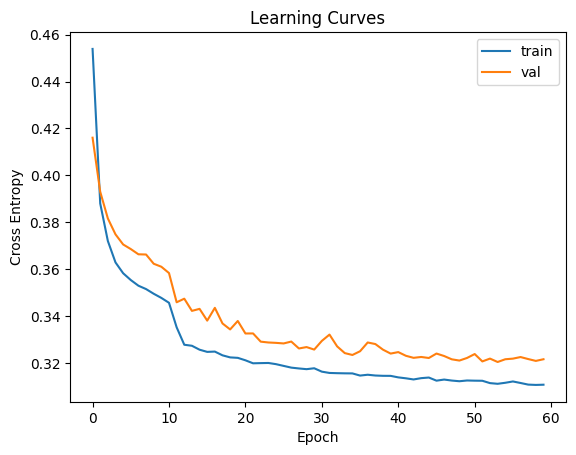

In [30]:
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

# Gabage Collect 

In case we run this notebook for too long and has too much uncollected garbage

In [31]:
import gc 
gc.collect() 

7279